In [2]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import spacy
import gensim
from tqdm import tqdm
from matplotlib import pyplot as plt
import apex

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

In [5]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
CRAWL_EMBEDDING_PATH = '../input/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove.840B.300d.txt'
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

In [7]:
'''
start_time = time.time()
spell_model = gensim.models.KeyedVectors.load_word2vec_format('../input/wiki-news-300d-1M.vec')
words = spell_model.index2word
w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank
del words
del w_rank
del spell_model
gc.collect()
print("--- %s seconds ---" % (time.time() - start_time))

# Use fast text as vocabulary
def words(text): return re.findall(r'\w+', text.lower())
def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)
def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])
'''

'\nstart_time = time.time()\nspell_model = gensim.models.KeyedVectors.load_word2vec_format(\'../input/wiki-news-300d-1M.vec\')\nwords = spell_model.index2word\nw_rank = {}\nfor i,word in enumerate(words):\n    w_rank[word] = i\nWORDS = w_rank\ndel words\ndel w_rank\ndel spell_model\ngc.collect()\nprint("--- %s seconds ---" % (time.time() - start_time))\n\n# Use fast text as vocabulary\ndef words(text): return re.findall(r\'\\w+\', text.lower())\ndef P(word): \n    "Probability of `word`."\n    # use inverse of rank as proxy\n    # returns 0 if the word isn\'t in the dictionary\n    return - WORDS.get(word, 0)\ndef correction(word): \n    "Most probable spelling correction for word."\n    return max(candidates(word), key=P)\ndef candidates(word): \n    "Generate possible spelling corrections for word."\n    return (known([word]) or known(edits1(word)) or [word])\ndef known(words): \n    "The subset of `words` that appear in the dictionary of WORDS."\n    return set(w for w in words if w

In [8]:

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))
    
def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

'''
def build_matrix(word_dict, lemma_dict, path):
    embed_size = 300
    embeddings_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_dict) + 1, embed_size), dtype=np.float32)
    unknown_words = []
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1
    
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        
        #Unknown word, does not exist in dictionary
        embedding_matrix[word_dict[key]] = unknown_vector
        unknown_words.append(word)
    return embedding_matrix, unknown_words
'''

'\ndef build_matrix(word_dict, lemma_dict, path):\n    embed_size = 300\n    embeddings_index = load_embeddings(path)\n    embedding_matrix = np.zeros((len(word_dict) + 1, embed_size), dtype=np.float32)\n    unknown_words = []\n    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1\n    \n    for key in tqdm(word_dict):\n        word = key\n        embedding_vector = embeddings_index.get(word)\n        if embedding_vector is not None:\n            embedding_matrix[word_dict[key]] = embedding_vector\n            continue\n        word = key.lower()\n        embedding_vector = embeddings_index.get(word)\n        if embedding_vector is not None:\n            embedding_matrix[word_dict[key]] = embedding_vector\n            continue\n        word = key.upper()\n        embedding_vector = embeddings_index.get(word)\n        if embedding_vector is not None:\n            embedding_matrix[word_dict[key]] = embedding_vector\n            continue\n        word = key.capitalize()\n    

In [9]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

filepath = './model_files/checkpoint.pth'

def train_model(model, train, test, loss_fn, output_dim, lr=0.001,
                batch_size=512, n_epochs=4, n_epochs_embed=2,
                enable_checkpoint_ensemble=True):
    
    train_collator = SequenceBucketCollator(lambda lengths: lengths.max(), 
                                            sequence_index=0, 
                                            length_index=1, 
                                            label_index=2)
    
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=train_collator)
    val_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=train_collator)
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    best_loss = 1
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train() #set model to train mode
        avg_loss = 0.
        
        for data in tqdm(train_loader, disable=False):
            
            #training loop
            x_batch = data[:-1]
            #print("First: ", x_batch[0][0])
            #print("Second: ", x_batch[0][1])
            first = x_batch[0][0]
            second = x_batch[0][1]
            
            y_batch = data[-1]

            y_pred = model(first, second)  #feed data into model          
            loss = loss_fn(y_pred, y_batch)
            
            #calculate error and adjust model params

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
        
        #Check if loss is better than current best loss, if so, save the model
        is_best = (avg_loss < best_loss)
        
        if is_best:
            print ("=> Saving a new best")
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss
            }, filepath)  # save checkpoint
        else:
            print ("=> Model Accuracy did not improve")
            
        
        model.eval() #set model to eval mode for test data
        test_preds = np.zeros((len(test), output_dim))
        
    
        for i, x_batch in enumerate(val_loader):
            #print("X_Batch: ", x_batch)
            data_param = x_batch[0][0]
            lengths_param = x_batch[0][1]
            y_pred = sigmoid(model(data_param, lengths_param).detach().cpu().numpy()) #feed data into model

            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred #get test predictions
        
        #test_preds has the predictions for the entire test set now
        all_test_preds.append(test_preds) #append predictions to the record of all past predictions
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, elapsed_time))
        
    #Make embeddings layer only layer unfreezed, train again (literally run through the n_epochs)
    #maybe define a n_epochs_embedding
    
    #parameters = model.parameters()
    #for param in parameters:
    #        param.requires_grad = False
    #parameters[0].requires_grad = True
    
    '''
    ct = 0
    for child in model.children():
        if ct == 0:
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False
        ct += 1
    
    for epoch in range(n_epochs_embed):
        start_time = time.time()
        
        scheduler.step()
        
        model.train() #set model to train mode
        avg_loss = 0.
        
        for data in tqdm(train_loader, disable=False):
            
            #training loop
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred = model(*x_batch)  #feed data into model          
            loss = loss_fn(y_pred, y_batch)
            
            #calculate error and adjust model params

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader) #gets the loss per epoch
        
            
        model.eval() #set model to eval mode for test data
        test_preds = np.zeros((len(test), output_dim))
    
        for i, x_batch in enumerate(test_loader):
            y_pred = sigmoid(model(*x_batch).detach().cpu().numpy()) #feed data into model

            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred #get test predictions
        
        #test_preds has the predictions for the entire test set now
        #all_test_preds.append(test_preds) #append predictions to the record of all past predictions
        elapsed_time = time.time() - start_time
        print('[EMBEDDING TRAINING] Epoch {}/{} \t loss={:.4f} \t time={:.2f}s '.format(
              epoch + 1, n_epochs_embed, avg_loss, elapsed_time))
    '''
    
    #PREDICTION CODE
    '''
    if enable_checkpoint_ensemble:
        #if our approach is an ensemble then we average it amongst all the historical predictions
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        #if our approach is not an ensemble then we just take the last set of predictions
        test_preds = all_test_preds[-1]
        
    return test_preds
    '''
    
    #return trained model
    return model

def predict(model, test, output_dim, batch_size=512, pred_type="val"):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if pred_type == "test":
        test_collator = SequenceBucketCollator(lambda lengths: lengths.max(), sequence_index=0, length_index=1)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=test_collator)

        model.eval() #set model to eval mode for test data
        test_preds = np.zeros((len(test), output_dim))

        for i, x_batch in enumerate(test_loader):
            #print(x_batch[0])
            data_param = x_batch[0]
            lengths_param = x_batch[1]
            y_pred = sigmoid(model(data_param, lengths_param).detach().cpu().numpy()) #feed data into model
            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred #get test predictions

        return test_preds
    else:
        test_collator = SequenceBucketCollator(lambda lengths: lengths.max(), sequence_index=0, length_index=1, label_index=2)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=test_collator)

        model.eval() #set model to eval mode for test data
        test_preds = np.zeros((len(test), output_dim))

        for i, x_batch in enumerate(test_loader):
            #print(x_batch)
            data_param = x_batch[0][0]
            lengths_param = x_batch[0][1]
            y_pred = sigmoid(model(data_param, lengths_param).detach().cpu().numpy()) #feed data into model
            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred #get test predictions

        return test_preds

In [11]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        #call the forward method in Dropout2d (super function specifies the subclass and instance)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        #call the init mthod in Module (super function specifies the subclass and instance)
        super(NeuralNet, self).__init__() 
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        #first variable h_(lstm #) holds the output, _ is the (hidden state, cell state)
        h_lstm1, _ = self.lstm1(h_embedding) 
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1) #get the mean value of the first dimension in h_lstm2
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1) #get the max value of the first dimension in h_lstm2
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [12]:
'''
def preprocess(data):

    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data
'''
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

from nltk.tokenize.treebank import TreebankWordTokenizer
nltk_tokenizer = TreebankWordTokenizer()


isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = nltk_tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [13]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
#pd.read_csv("P00000001-ALL.csv", nrows=20)
#train = pd.read_hdf('../input/train.h5')
#test = pd.read_hdf('../input/test.h5')
#tqdm.pandas()

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

x_train = train['comment_text'].apply(lambda x:preprocess(x))
y_train = np.where(train['target'] >= 0.5, 1, 0)
num_train_data = y_train.shape[0]
y_train_identity = np.where(train[identity_columns] >= 0.5, 1, 0)
y_aux_train = train[['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
x_test = test['comment_text'].apply(lambda x:preprocess(x))
y_aux_train = y_aux_train.as_matrix()

/home/curtis/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
'''
max_features = None

#Create the dictionary of all words that exist in our data
nlp = spacy.load("en_core_web_lg", disable=['parser','ner','tagger'])
text_list = pd.concat([x_train, x_test])
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
word_dict = {}
lemma_dict = {}
word_index = 1
docs = nlp.pipe(text_list, n_threads = 2)
word_sequences = []
'''

'\nmax_features = None\n\n#Create the dictionary of all words that exist in our data\nnlp = spacy.load("en_core_web_lg", disable=[\'parser\',\'ner\',\'tagger\'])\ntext_list = pd.concat([x_train, x_test])\nnlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)\nword_dict = {}\nlemma_dict = {}\nword_index = 1\ndocs = nlp.pipe(text_list, n_threads = 2)\nword_sequences = []\n'

In [15]:
#create dictionary of word mapping to integers as wel as lemma dictionary
#count = 1
'''
start_time = time.time()
for doc in tqdm(docs): #one doc is one comment(row)
    #print(count)
    word_seq = []
    for token in doc:
        if (token.text not in word_dict) and (token.pos_ is not "PUNCT"):
            word_dict[token.text] = word_index
            word_index += 1
            lemma_dict[token.text] = token.lemma_
        if token.pos_ is not "PUNCT":
            word_seq.append(word_dict[token.text])
    word_sequences.append(word_seq)
    #count+= 1

print("--- %s seconds ---" % (time.time() - start_time))
del docs
del text_list
gc.collect()
'''

'\nstart_time = time.time()\nfor doc in tqdm(docs): #one doc is one comment(row)\n    #print(count)\n    word_seq = []\n    for token in doc:\n        if (token.text not in word_dict) and (token.pos_ is not "PUNCT"):\n            word_dict[token.text] = word_index\n            word_index += 1\n            lemma_dict[token.text] = token.lemma_\n        if token.pos_ is not "PUNCT":\n            word_seq.append(word_dict[token.text])\n    word_sequences.append(word_seq)\n    #count+= 1\n\nprint("--- %s seconds ---" % (time.time() - start_time))\ndel docs\ndel text_list\ngc.collect()\n'

In [16]:
max_features = 400000
tokenizer = text.Tokenizer(num_words = max_features, filters='',lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
#max_features = max_features or len(word_dict) + 1
max_features = max_features or len(tokenizer.word_index) + 1
max_features #number of unique words there are in the dictionary

400000

In [18]:
start_time = time.time()
#crawl_matrix, unknown_words_crawl = build_matrix(word_dict, lemma_dict, CRAWL_EMBEDDING_PATH)
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))
print("--- %s seconds ---" % (time.time() - start_time))
print('Size: ', crawl_matrix.shape)
del unknown_words_crawl
gc.collect()

n unknown words (crawl):  222943
--- 74.586101770401 seconds ---
Size:  (487814, 300)


0

In [19]:
start_time = time.time()
#glove_matrix, unknown_words_glove = build_matrix(word_dict, lemma_dict, GLOVE_EMBEDDING_PATH)
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))
print("--- %s seconds ---" % (time.time() - start_time))
print('Size: ', glove_matrix.shape)
del unknown_words_glove
gc.collect()

n unknown words (glove):  225246
--- 84.45934987068176 seconds ---
Size:  (487814, 300)


0

In [20]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)

del crawl_matrix
del glove_matrix
#del word_dict
#del lemma_dict
#del WORDS
gc.collect()

0

In [21]:
class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = y_true
        self.y_i = y_identity
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        #print(self.y)
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        #print(y_pred)
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            #print(y_pred)
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

In [22]:
#x_train = word_sequences[:num_train_data]
#x_test = word_sequences[num_train_data:]
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))
test_lengths = torch.from_numpy(np.array([len(x) for x in x_test]))
print(len(x_train))
print(lengths.shape)
maxlen = int(np.percentile(lengths, 95)) 
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print(maxlen)
print(lengths.max())

1804874
torch.Size([1804874])
188
tensor(713)


In [23]:
print(x_train.shape)
print(y_train.shape)
print(num_train_data)

(1804874, 188)
(1804874,)
1804874


In [24]:
#Here, we use one model that filters out all the easy predictions
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
train_dataset = data.TensorDataset(x_train_torch, lengths ,y_train_torch)

print('Model: PRELIM FILTER')
seed_everything(1234)

model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
model.cuda()

#training using training and validation set
model = train_model(model, train_dataset, train_dataset, output_dim=y_train_torch.shape[-1], 
                         loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))


#prediction on entire train set
pred = predict(model, train_dataset, output_dim=y_train_torch.shape[-1])[:,0]

evaluator = JigsawEvaluator(y_train, y_train_identity)
auc_score = evaluator.get_final_metric(pred)
roc_score = roc_auc_score(y_train, pred)

print('Kaggle Score: ', auc_score)
print('ROC score: ', roc_score)

        
print('====================== END OF FILTER =============================')

Model: PRELIM FILTER
=> Saving a new best
Epoch 1/4 	 loss=0.0809 	 time=655.38s
=> Saving a new best
Epoch 2/4 	 loss=0.0746 	 time=657.73s
=> Saving a new best
Epoch 3/4 	 loss=0.0735 	 time=658.63s
=> Saving a new best
Epoch 4/4 	 loss=0.0728 	 time=659.25s
Kaggle Score:  0.9398711312814203
ROC score:  0.9735292218007326
====================== END OF FILTER =============================


In [25]:
#CLEAR 
del x_train_torch
del y_train_torch
del train_dataset
gc.collect()

0

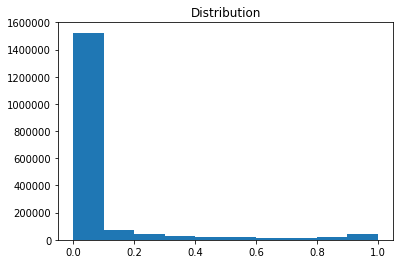

In [26]:
#AND GET DISTRIBUTIONS OF PREDICTIONS
plt.hist(pred)
plt.title("Distribution")
plt.show()

In [27]:
for i in range(1, 100):
    thres = np.percentile(pred, i)
    print('{}% of comments have a score of less than {}'.format(i, thres))

1% of comments have a score of less than 4.716167048172792e-05
2% of comments have a score of less than 5.7090710470220074e-05
3% of comments have a score of less than 6.539529422298074e-05
4% of comments have a score of less than 7.316590199479833e-05
5% of comments have a score of less than 8.071067350101657e-05
6% of comments have a score of less than 8.820692572044208e-05
7% of comments have a score of less than 9.578832396073267e-05
8% of comments have a score of less than 0.00010333054960938172
9% of comments have a score of less than 0.00011116965142718982
10% of comments have a score of less than 0.00011926486113225112
11% of comments have a score of less than 0.00012766249346896075
12% of comments have a score of less than 0.00013632517249789088
13% of comments have a score of less than 0.00014525270671583712
14% of comments have a score of less than 0.00015454382781172172
15% of comments have a score of less than 0.00016420407991972754
16% of comments have a score of less tha

In [33]:
#FILTER OUT ALL THE EASY COMMENTS (64th percentile)
threshold = np.percentile(pred, 64)
print(threshold)
keep_index = (pred > threshold)
print(keep_index)


0.03767282366752625
[ True  True  True ...  True  True  True]


In [29]:
x_train_orig = x_train
y_train_orig = y_train
y_train_identity_orig = y_train_identity

x_train = x_train[np.where(keep_index)]
y_train = y_train[np.where(keep_index)]
y_train_identity = y_train_identity[np.where(keep_index)]
y_aux_train = y_aux_train[np.where(keep_index)]


In [30]:
pred = pred[np.where(keep_index)]

In [31]:
evaluator = JigsawEvaluator(y_train, y_train_identity)
auc_score = evaluator.get_final_metric(pred)
roc_score = roc_auc_score(y_train, pred)

print('Kaggle Score: ', auc_score)
print('ROC score: ', roc_score)

Kaggle Score:  0.9041709031652599
ROC score:  0.9217058856253003


In [34]:
del pred
del model
gc.collect()

2798

In [36]:
filtered_indices = np.where(keep_index)[0]
print("Filtered indices: ", filtered_indices)
print("Filtered indices len: ", filtered_indices)
all_val_preds = []
all_test_preds = []
num_splits = 5

#Add in K fold 
random_state = 2019

#K fold splits
splits = list(StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=random_state).split(x_train,y_train))

#final validation predictions
final_val_preds = np.zeros((x_train_orig.shape[0])) #change to x train original shape

#final test predictions to be stored in this var
final_test_preds = np.zeros((x_test.shape[0]))

start_time = time.time()
for fold in range(num_splits):
    tr_ind, val_ind = splits[fold]
    print('Val indices: ', val_ind)
    val_ind_orig = filtered_indices[val_ind]
    print('Original Val Indicies: ', val_ind_orig)
    all_val_preds = []
    all_test_preds = []
    #print('Training set size: ', len(tr_ind))
    #print('Val set size: ', len(val_ind))
    x_training = x_train[tr_ind]
    y_training = y_train[tr_ind]
    y_aux_training = y_aux_train[tr_ind]
    
    x_val = x_train[val_ind]
    y_val = y_train[val_ind]
    y_aux_val = y_aux_train[val_ind]
    
    
    
    x_train_torch = torch.tensor(x_training, dtype=torch.long).cuda()
    x_val_torch = torch.tensor(x_val, dtype=torch.long).cuda()
    y_train_torch = torch.tensor(np.hstack([y_training[:, np.newaxis], y_aux_training]), dtype=torch.float32).cuda()
    y_val_torch = torch.tensor(np.hstack([y_val[:, np.newaxis], y_aux_val]), dtype=torch.float32).cuda()
    
    x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
    
    ###
    
    #test_dataset = data.TensorDataset(x_test_torch, test_lengths)
    #train_dataset = data.TensorDataset(x_train_torch, lengths, y_train_torch)
    #val_dataset = data.TensorDataset(x_val_torch)

    #train_collator = SequenceBucketCollator(lambda lengths: lengths.max(), sequence_index=0, length_index=1, label_index=2)
    #test_collator = SequenceBucketCollator(lambda lengths: lengths.max(), sequence_index=0, length_index=1)
    
    ####
    train_dataset = data.TensorDataset(x_train_torch, lengths[tr_ind], y_train_torch)
    val_dataset = data.TensorDataset(x_val_torch, lengths[val_ind], y_val_torch)
    test_dataset = data.TensorDataset(x_test_torch, test_lengths)
    
    #temp_dataset = data.Subset(train_dataset, indices=[0, 1])

    for model_idx in range(NUM_MODELS):
        print('Model ', model_idx)
        seed_everything(1234 + model_idx)

        model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
        model.cuda()

        #training using training and validation set
        model = train_model(model, train_dataset, val_dataset, output_dim=y_train_torch.shape[-1], loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
        
        #prediction on validation set (used for score measurement)
        val_pred = predict(model, val_dataset, output_dim=y_train_torch.shape[-1], pred_type="val") #val preds on the val split
        all_val_preds.append(val_pred)
        #print(len(val_pred))
        
        #prediction on entire test set (actual predictions to be submitted)
        test_pred = predict(model, test_dataset, output_dim=y_train_torch.shape[-1], pred_type="test")
        all_test_preds.append(test_pred)
        
        print()
        
    #average validation prediction amongst all models
    avg_val = np.mean(all_val_preds, axis=0)[:, 0] #will be printed out per split
    final_val_preds[val_ind_orig] += avg_val
    
    avg_test = np.mean(all_test_preds, axis=0)[:, 0]
    
    final_test_preds += avg_test #get all test scores for every split (will be averaged out at the end)

    y_true = y_train[val_ind] #true scores for this validation set
    y_identity = y_train_identity[val_ind] #true scores for the identity groups for this validation set
    evaluator = JigsawEvaluator(y_true, y_identity)
    auc_score = evaluator.get_final_metric(avg_val)

    roc_score = roc_auc_score(y_train[val_ind], avg_val)
    print('Kaggle Score: ', auc_score)
    print('ROC score: ', roc_score)
    
    del x_train_torch
    del x_val_torch
    del y_train_torch
    del y_val_torch
    del x_test_torch
    del train_dataset
    del val_dataset
    del test_dataset
    gc.collect()
    torch.cuda.empty_cache()
    
    print('=============End-of-Fold================')
    
end_time = time.time()
print('Time: ', end_time - start_time)

#Final combined score
y_true = y_train_orig #y train original
y_identity = y_train_identity_orig #y train identity original
evaluator = JigsawEvaluator(y_true, y_identity)
auc_score = evaluator.get_final_metric(final_val_preds)
print('Final Kaggle Score: ', auc_score)
print('Final ROC score: ', roc_auc_score(y_train_orig, final_val_preds))

#average test predictions AGAIN this time by number of splits
final_test_preds /= num_splits
#print(final_test_preds)

Filtered indices:  [     0      1      2 ... 649752 649753 649754]
Filtered indices len:  [     0      1      2 ... 649752 649753 649754]
Val indices:  [     0      9     23 ... 649734 649741 649752]


IndexError: index 389854 is out of bounds for axis 1 with size 389853

In [33]:
'''
def threshold_search(y_true, y_identity, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        evaluator = JigsawEvaluator(y_true, y_identity)
        score = evaluator.get_final_metric(y_proba > threshold)
        print("Threshold: {} , Score: {} ".format(threshold, score))
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'kaggle_score': best_score}
    return search_result
'''

'\ndef threshold_search(y_true, y_identity, y_proba):\n    best_threshold = 0\n    best_score = 0\n    for threshold in [i * 0.01 for i in range(100)]:\n        evaluator = JigsawEvaluator(y_true, y_identity)\n        score = evaluator.get_final_metric(y_proba > threshold)\n        print("Threshold: {} , Score: {} ".format(threshold, score))\n        if score > best_score:\n            best_threshold = threshold\n            best_score = score\n    search_result = {\'threshold\': best_threshold, \'kaggle_score\': best_score}\n    return search_result\n'

In [34]:
'''threshold = threshold_search(y_true, y_identity, final_val_preds)
print(threshold)
thres_diff = 0.5 - threshold["threshold"]
print("Threshold difference: ", thres_diff)'''

'threshold = threshold_search(y_true, y_identity, final_val_preds)\nprint(threshold)\nthres_diff = 0.5 - threshold["threshold"]\nprint("Threshold difference: ", thres_diff)'

In [35]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': final_test_preds
})

submission.to_csv('submission.csv', index=False)
submission.head()

,id,prediction
0,7000000,0.020993
1,7000001,0.004992
2,7000002,0.018071
3,7000003,0.009714
4,7000004,0.976520
